# Import dependencies

In [1]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D,Dense,MaxPooling2D,Input,Flatten
import tensorflow as tf

# GPU growth

In [3]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [189]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
for gpu in gpus:
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Create Folder Strucutures

In [6]:
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [7]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# Collect Postive(correct) and Anchor(cam) Images

Anchor and positive images comes from webcaM
NEGAtive images comes from labeled faces in the wild dataset

# collecting untar labelled faces from wild dataset

http://vis-www.cs.umass.edu/lfw/
download images from this link

shift the data from lfw images to data/negative folder

In [10]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH = os.path.join('lfw',directory,file)
        NEW_PATH = os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

now the upper cell will not work because we deleted the lfw file

# Collect Positive and Anchor class images

In [23]:
#establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    #show image back to screen
    cv2.imshow('Image Collection',frame)
    #breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
#release the webcam
cap.release()
cv2.destroyAllWindows()

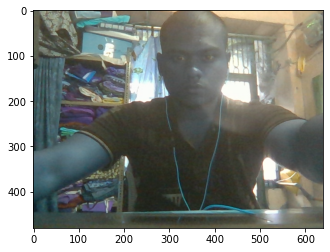

In [24]:
plt.imshow(frame)

In [25]:
frame.shape

(480, 640, 3)

but we want images of size 250,250 so we slice the index of frame

In [26]:
frame[120:120+250,120:120+250,:].shape

(250, 250, 3)

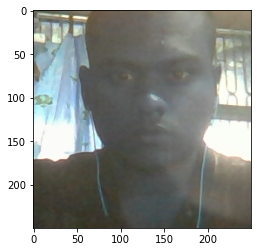

In [35]:
plt.imshow(frame[30:30+250,220:220+250,:])
#i adjusted the frame position to capture my face according to my camera

In [36]:
#establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    frame = frame[30:30+250,220:220+250,:]
    #show image back to screen
    cv2.imshow('Image Collection',frame)
    #breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
#release the webcam
cap.release()
cv2.destroyAllWindows()

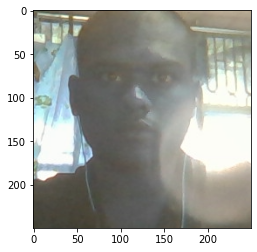

In [37]:
plt.imshow(frame)

# now finally collect anchors and positive images

In [38]:
#import uuid library to generate unique names for images
import uuid


In [40]:
#establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    frame = frame[30:30+250,220:220+250,:]
    #collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname,frame)
    #collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname,frame)
    
    #show image back to screen
    cv2.imshow('Image Collection',frame)
    #breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
#release the webcam
cap.release()
cv2.destroyAllWindows()

# Load and preprocess Images
# 1) Get image directories
# 2) Preprocessing -scale and resize
# 3) create labelled dataset
# 4) build train and test partition

In [41]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(400)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(400)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(400)

In [44]:
dir_test = anchor.as_numpy_iterator()

In [45]:
# dir_test.next()

In [49]:
def preprocess(file_path):
    #read in image from file path
    byte_img = tf.io.read_file(file_path)
    #load in the image
    img = tf.io.decode_jpeg(byte_img)
    #preprocessing image
    #resizing image to 100,100,3 because the siamese network we are taking having input shape 100,100,3
    img = tf.image.resize(img,(100,100))
    #scaling image between 0 and 1
    img = img/255.0
    #returning our image
    return img

In [51]:
img = preprocess(dir_test.next())

In [52]:
img

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.28970587, 0.36519608, 0.35661766],
        [0.28480393, 0.3602941 , 0.33382353],
        [0.2622549 , 0.33259803, 0.29240197],
        ...,
        [0.3745098 , 0.4764706 , 0.5294118 ],
        [0.3737745 , 0.4757353 , 0.54044116],
        [0.37426472, 0.4762255 , 0.54289216]],

       [[0.2504902 , 0.30514705, 0.3345588 ],
        [0.5379902 , 0.59656864, 0.60612744],
        [0.5767157 , 0.6389706 , 0.63186276],
        ...,
        [0.36985293, 0.46887255, 0.52230394],
        [0.36764705, 0.46666667, 0.5259804 ],
        [0.36568627, 0.46470588, 0.53039217]],

       [[0.31715685, 0.35735294, 0.3647059 ],
        [0.39558825, 0.44387254, 0.44828433],
        [0.38382354, 0.4387255 , 0.44754902],
        ...,
        [0.37720588, 0.46960783, 0.52009803],
        [0.37720588, 0.46740195, 0.5237745 ],
        [0.37254903, 0.4627451 , 0.51960784]],

       ...,

       [[0.7031863 , 0.67696077, 0.58480394],
        [0.77

In [54]:
img.numpy().max()#scaling

1.0

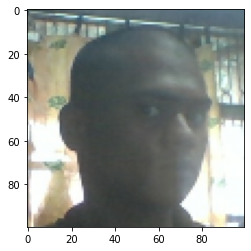

In [55]:
plt.imshow(img)

In [58]:
#tf.ones_like() it represents the data of array in terms of a single value 1
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [59]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

above first Tensorspec refers to anchor image, second one referes to positive, negative images, third one referes to labels => (0,1)

In [61]:
class_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))
iterator_labs = class_labels.as_numpy_iterator()
iterator_labs.next()

0.0

In [62]:
samples = data.as_numpy_iterator()

In [65]:
example = samples.next()
example

(b'data\\anchor\\b86a4a53-f3a1-11ec-97c7-7c8ae139c48b.jpg',
 b'data\\positive\\0467cbfb-f3a2-11ec-b8e3-7c8ae139c48b.jpg',
 1.0)

In [64]:
def preprocess_twin(input_img,validation_img,label):
    return(preprocess(input_img),preprocess(validation_img),label)

In [67]:
result = preprocess_twin(*example)# star is for unpacking the values of that tuple

In [77]:
result

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.31985295, 0.37941176, 0.39044118],
         [0.34681374, 0.42328432, 0.40318626],
         [0.3242647 , 0.4014706 , 0.37426472],
         ...,
         [0.44485295, 0.55465686, 0.5977941 ],
         [0.4509804 , 0.56078434, 0.6039216 ],
         [0.4509804 , 0.56078434, 0.60784316]],
 
        [[0.29240197, 0.3409314 , 0.38210785],
         [0.57034314, 0.63210785, 0.64730394],
         [0.63161767, 0.70955884, 0.7022059 ],
         ...,
         [0.43235293, 0.5441176 , 0.575     ],
         [0.44215685, 0.5517157 , 0.59068626],
         [0.43529412, 0.5441176 , 0.5872549 ]],
 
        [[0.3627451 , 0.3970588 , 0.42892158],
         [0.43970588, 0.50147057, 0.5122549 ],
         [0.42009804, 0.49656862, 0.49362746],
         ...,
         [0.42156863, 0.527451  , 0.5568628 ],
         [0.42769608, 0.53357846, 0.5688726 ],
         [0.4360294 , 0.5419118 , 0.58504903]],
 
        ...,
 
        [[0.29828432, 0.3394608 

In [71]:
len(result)

3

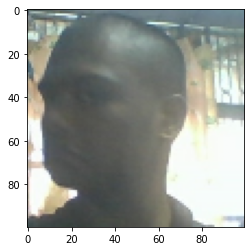

In [80]:
plt.imshow(result[0])

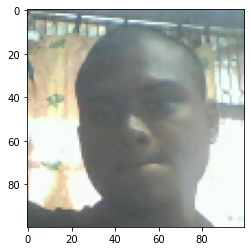

In [79]:
plt.imshow(result[1])

In [81]:
#build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [82]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [83]:
samples = data.as_numpy_iterator()

In [86]:
samples.next()

(array([[[0.34387255, 0.3987745 , 0.4034314 ],
         [0.37132353, 0.4117647 , 0.40294117],
         [0.35196078, 0.39313725, 0.3647059 ],
         ...,
         [0.47549018, 0.56960785, 0.6166667 ],
         [0.48235294, 0.5764706 , 0.62352943],
         [0.48235294, 0.57254905, 0.627451  ]],
 
        [[0.29264706, 0.3492647 , 0.375     ],
         [0.6377451 , 0.67965686, 0.6904412 ],
         [0.6879902 , 0.73088235, 0.72181374],
         ...,
         [0.47671568, 0.5708333 , 0.610049  ],
         [0.47132352, 0.5654412 , 0.60906863],
         [0.46348038, 0.56936276, 0.6105392 ]],
 
        [[0.39534312, 0.41985294, 0.44142157],
         [0.46348038, 0.49583334, 0.50808823],
         [0.48039216, 0.5245098 , 0.52794117],
         ...,
         [0.46764705, 0.5617647 , 0.6068627 ],
         [0.46372548, 0.55784315, 0.5985294 ],
         [0.45588234, 0.5617647 , 0.59705883]],
 
        ...,
 
        [[0.8308824 , 0.7497549 , 0.65367645],
         [0.860049  , 0.80784315, 0.71911

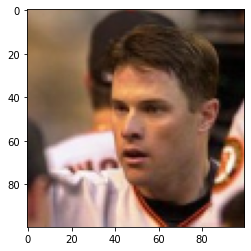

In [94]:
plt.imshow(samples.next()[1])

In [95]:
#training partition
train_data = data.take(round(len(data)*.7))#70% data for training partition
train_data = train_data.batch(16)#we will pass the data as batches of each batch containes 16 images rows
train_data = train_data.prefetch(8)#starts preprocessing the next set of images so that we dont bottle neck our neural network

In [96]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [98]:
train_samples = train_data.as_numpy_iterator()
train_sample = train_samples.next()
len(train_sample[0])

16

In [99]:
#testing partition
test_data = data.skip(round(len(data)*.7))
test_data=test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [100]:
test_samples = test_data.as_numpy_iterator()
test_sample = test_samples.next()
len(test_sample[0])

16

# Model Engineering

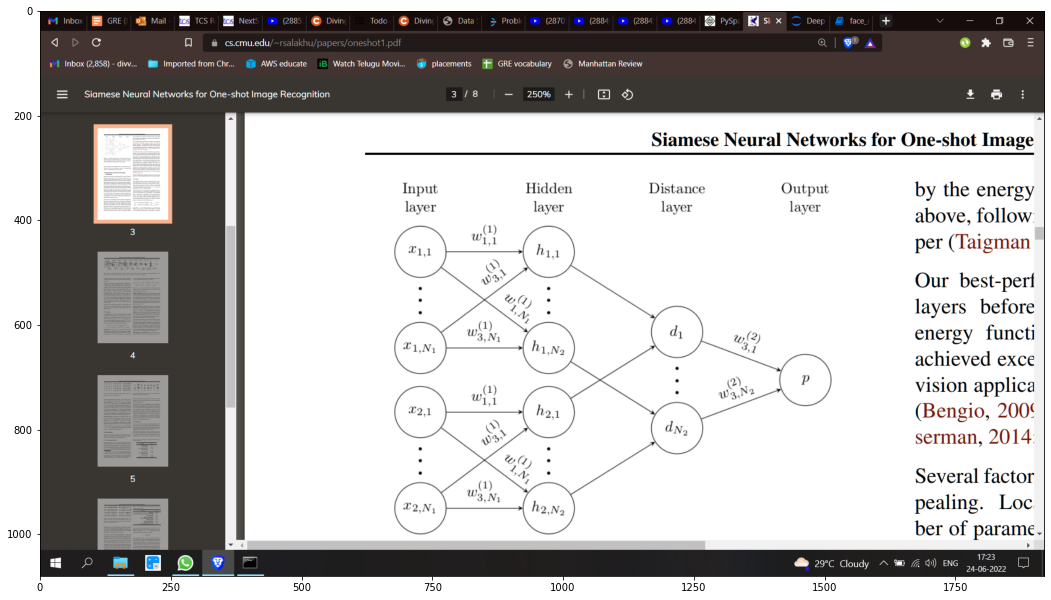

In [112]:
plt.figure(figsize = (18,12))
plt.imshow(cv2.imread("Screenshot (127).png"))

the above image is the architecture for the neural network we are going to build

1. Build Embedding layer
2. Build Distance Layer
3. Make siamese model

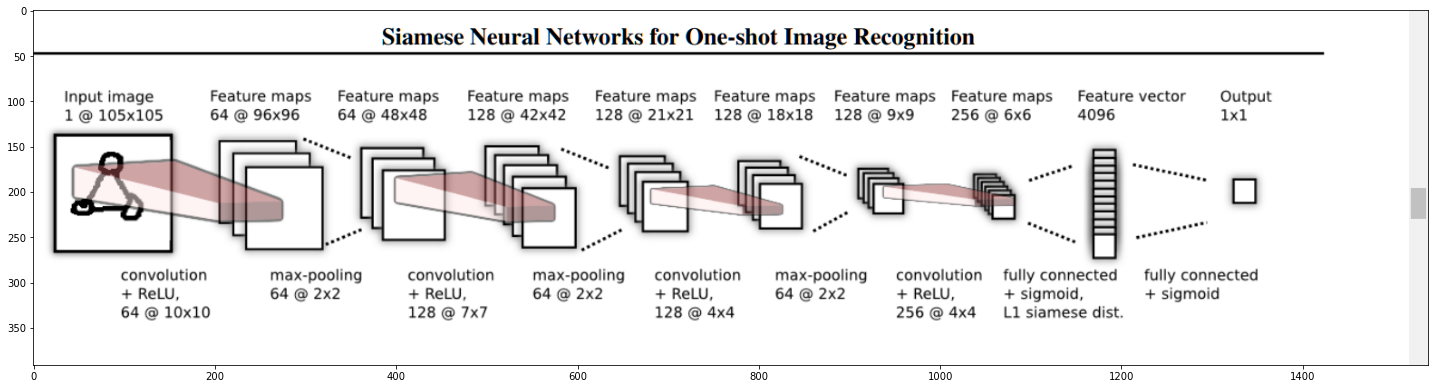

In [114]:
plt.figure(figsize = (25,12))
plt.imshow(cv2.imread("Screenshot (129).png"))

In [116]:
inp = Input(shape=(100,100,3),name='input_image')
c1 = Conv2D(64,(10,10),activation='relu')(inp) 
m1 = MaxPooling2D(64,(2,2),padding='same')(c1)
m1

<KerasTensor: shape=(None, 46, 46, 64) dtype=float32 (created by layer 'max_pooling2d')>

# Building Embedding layer

In [117]:
def make_embedding():
    inp = Input(shape=(100,100,3),name='input_image')
    #first block
    c1 = Conv2D(64,(10,10),activation='relu')(inp)  #(10,10) is the size of kernel
    m1 = MaxPooling2D(64,(2,2),padding='same')(c1)
    #second block
    c2 = Conv2D(128,(7,7),activation='relu')(m1)
    m2=MaxPooling2D(64,(2,2),padding='same')(c2)
    #third block
    c3 = Conv2D(128,(4,4),activation='relu')(m2)
    m3=MaxPooling2D(64,(2,2),padding='same')(c3)
    #final embedding block
    c4 = Conv2D(256,(4,4),activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096,activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp],outputs=[d1],name='embedding')

In [126]:
embedding = make_embedding()

In [127]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 17, 17, 128)       26

# Distance layer

In [122]:
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()
    
    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [123]:
l1 = L1Dist()

In [125]:
# l1(anchor_embedding,validation_embedding)

# Make siamese model

In [129]:
input_image = Input(name='input_img',shape=(100,100,3))
input_embedding = embedding(input_image)
validation_image = Input(name='validation_img',shape=(100,100,3))
validation_embedding = embedding(validation_image)

In [132]:
siamese_layer = L1Dist()
siamese_layer(input_embedding,validation_embedding)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'l1_dist_3')>

In [133]:
def make_siamese_model():
    #Anchor image input in the network
    input_image = Input(name='input_img',shape=(100,100,3))
    
    #validation image input in the network
    validation_image = Input(name='validation_img',shape=(100,100,3))
    
    #combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name='distance'
    distances = siamese_layer(embedding(input_image),embedding(validation_image))
    
    #classification layer
    classifier = Dense(1,activation='sigmoid')(distances)
    
    return Model(inputs=[input_image,validation_image],outputs=classifier,name='SiameseNetwork')
    

In [134]:
siamese_model=make_siamese_model()

In [135]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Training

1. Setup loss and optimizer
2. establish checkpoints
3. build train step function
4. build training loop
5. train the model

In [136]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [137]:
opt = tf.keras.optimizers.Adam(1e-4)#learning rate 0.001

In [159]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt,siamese_model=siamese_model)

In [140]:
test_batch = train_data.as_numpy_iterator()

In [141]:
batch1 = test_batch.next()

In [143]:
len(batch1[1])

16

In [144]:
batch1[2]

array([1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0.],
      dtype=float32)

In [145]:
X = batch1[:2]

In [147]:
Y=batch1[2]

In [155]:
@tf.function
def train_step(batch):
    #record all of our operations
    with tf.GradientTape() as tape:
        #get anchar and positive/negative image
        x=batch[:2]
        #get label
        y=batch[2]
        
        #forward pass
        yhat = siamese_model(x,training=True)
        #calculate loss
        loss = binary_cross_loss(y,yhat)
    grad = tape.gradient(loss,siamese_model.trainable_variables)
    #calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    return loss

# Build training loop

In [156]:
def train(data,EPOCHS):
    #loop through the epochs
    for epoch in range(1,EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch,EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
    
    #loop through each batch
        for idx,batch in enumerate(data):
        #Run train step here
            train_step(batch)
            progbar.update(idx+1)
        #save checkpoints for every ten epochs
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        

# Train the model

In [157]:
EPOCHS = 50

In [160]:
train(train_data,EPOCHS)


 Epoch 1/50
35/35 [==============================] - 7s 191ms/step

 Epoch 2/50
35/35 [==============================] - 6s 184ms/step

 Epoch 3/50
35/35 [==============================] - 6s 185ms/step

 Epoch 4/50
35/35 [==============================] - 6s 186ms/step

 Epoch 5/50
35/35 [==============================] - 6s 187ms/step

 Epoch 6/50
35/35 [==============================] - 7s 188ms/step

 Epoch 7/50
35/35 [==============================] - 7s 189ms/step

 Epoch 8/50
35/35 [==============================] - 7s 191ms/step

 Epoch 9/50
35/35 [==============================] - 7s 191ms/step

 Epoch 10/50
35/35 [==============================] - 7s 190ms/step

 Epoch 11/50
35/35 [==============================] - 6s 190ms/step

 Epoch 12/50
35/35 [==============================] - 7s 191ms/step

 Epoch 13/50
35/35 [==============================] - 7s 191ms/step

 Epoch 14/50
35/35 [==============================] - 7s 192ms/step

 Epoch 15/50
35/35 [======================

# Evaluate Model, test the model

In [161]:
from tensorflow.keras.metrics import Precision,Recall

In [162]:
test_input, test_val,y_true = test_data.as_numpy_iterator().next()

In [163]:
predictions = siamese_model.predict([test_input,test_val])

In [164]:
predictions

array([[9.9978691e-01],
       [9.9961650e-01],
       [9.9995756e-01],
       [3.7161423e-09],
       [1.0000000e+00],
       [6.4519412e-09],
       [1.0000000e+00],
       [8.6253715e-09],
       [2.1449739e-07],
       [1.0000000e+00],
       [9.9844724e-01],
       [9.9999785e-01],
       [9.9996710e-01],
       [1.0000000e+00],
       [6.6692941e-08],
       [1.0530024e-07]], dtype=float32)

In [166]:
#post processing the results
[1 if prediction >0.5 else 0 for prediction in predictions]

[1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0]

In [167]:
y_true

array([1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
      dtype=float32)

# we can see that above both those results are same

In [168]:
m = Recall()
m.update_state(y_true,predictions)
m.result().numpy()

1.0

that is 100% correct

In [169]:
m = Precision()
m.update_state(y_true,predictions)
m.result().numpy()

1.0

# Evaluate entire dataset

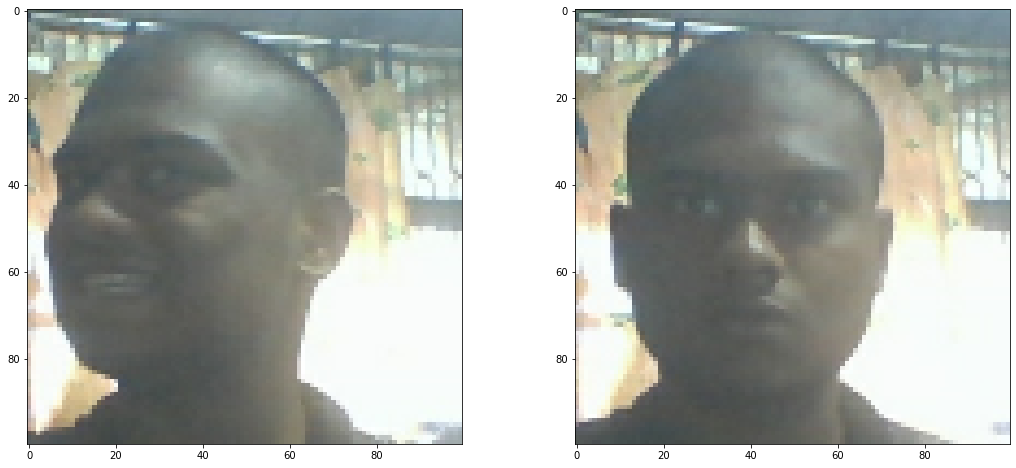

In [170]:
# visualizing the images of class 1
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[2])
plt.subplot(1,2,2)
plt.imshow(test_val[2])
plt.show()

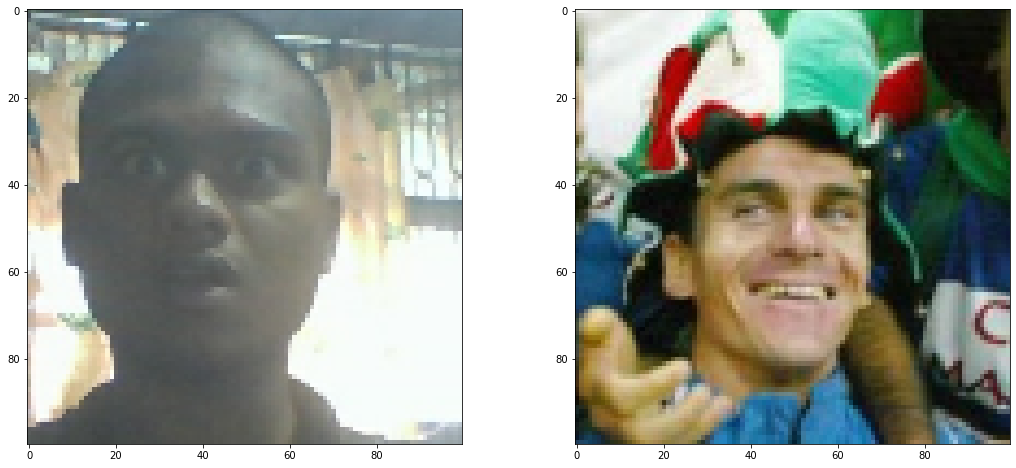

In [175]:
# visualizing the images of class 0
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[15])
plt.subplot(1,2,2)
plt.imshow(test_val[15])
plt.show()

# Save the model

In [176]:
siamese_model.save('siamesemodel.h5')

In [180]:
#reload model
model = tf.keras.models.load_model('siamesemodel.h5',custom_objects={'L1Dist':L1Dist})

In [181]:
test_input, test_val,y_true = test_data.as_numpy_iterator().next()
predictions = model.predict([test_input,test_val])
predictions

array([[9.9962330e-01],
       [9.2635105e-07],
       [1.4238888e-07],
       [9.9990273e-01],
       [6.7020657e-08],
       [3.7758824e-07],
       [6.9480755e-08],
       [9.9978167e-01],
       [1.9197605e-08],
       [9.9999774e-01],
       [7.2081043e-08],
       [6.4394037e-08],
       [4.0152443e-08],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.6883472e-08]], dtype=float32)

# Real Time test

## Verification Fuction

In [182]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified
    

## Opencv realtime verification

In [186]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[30:30+250,220:220+250,:]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True


In [187]:
np.squeeze(results) >0.5

array([ True,  True,  True, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False,  True,  True, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [188]:
len(np.squeeze(results) >0.5)

50